<a href="https://colab.research.google.com/github/ARAN-ai-python/SharePrices_AI/blob/main/jupyter%20notebook/%E6%A0%AA%E4%BE%A1%E4%BA%88%E6%B8%ACAI(stooq).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas_datareader import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import datetime

In [ ]:
#SharePricesGraphing = SPG
def wma(w):
    weight = np.arange(len(w)) + 1
    wma = np.sum(weight * w) / weight.sum()
    return wma

def ema(e,p):
    ema = np.zeros(len(e))
    ema[:] = np.nan
    ema[p-1] = e[:p].mean()
    
    for d in range(p,len(e)):
        ema[d] = ema[d-1] + (e[d] - e[d-1]) / (p+1) * 2
    return ema

def SPG(start,end,company_code):
    df = data.DataReader(company_code,"stooq")
    df = df[(df.index>=start) & (df.index<=end)]
    
    date = df.index
    price = df['Close']
    
    span01 = 5
    span02 = 25
    span03 = 50
    
    df['sma01'] = price.rolling(window=span01).mean()
    df['sma02'] = price.rolling(window=span02).mean()
    df['sma03'] = price.rolling(window=span03).mean()
    
    #weights = np.array([range(1,i) for i in [6,26,51]])
    #weights01 = [i for i in range(1,span01+1)]
    #weights02 = [i for i in range(1,span02+1)]
    #weights03 = [i for i in range(1,span03+1)]
    df['wma01'] = price.rolling(window=span01).apply(wma,raw=True).round(1)
    df['wma02'] = price.rolling(window=span02).apply(wma,raw=True).round(1)
    df['wma03'] = price.rolling(window=span03).apply(wma,raw=True).round(1)
    
    df['ema01'] = ema(price,span01).round(1)
    df['ema02'] = ema(price,span02).round(1)
    df['ema03'] = ema(price,span03).round(1)
    
    plt.figure(figsize=(30,15))
    
    #移動平均
    plt.subplot(4,1,1)
    plt.title('SMA',color='black',backgroundcolor='white',size=30,loc='center')
    plt.plot(date,price,label='Close',color='black')
    plt.plot(date,df['sma01'],label='sma01',color='red')
    plt.plot(date,df['sma02'],label='sma02',color='blue')
    plt.plot(date,df['sma03'],label='sma03',color='green')
    plt.legend()
    
    #加重移動平均
    plt.subplot(4,1,2)
    plt.title('WMA',color='black',backgroundcolor='white',size=30,loc='center')
    plt.plot(date,price,label='Close',color='black')
    plt.plot(date,df['wma01'],label='wma01',color='red')
    plt.plot(date,df['wma02'],label='wma02',color='blue')
    plt.plot(date,df['wma03'],label='wma03',color='green')
    plt.legend()
    
    #指数移動平均
    plt.subplot(4,1,3)
    plt.title('EMA',color='black',backgroundcolor='white',size=30,loc='center')
    plt.plot(date,price,label='Close',color='black')
    plt.plot(date,df['ema01'],label='ema01',color='red')
    plt.plot(date,df['ema02'],label='ema02',color='blue')
    plt.plot(date,df['ema03'],label='ema03',color='green')
    #print(df['ema01'],df['ema02'],df['ema03'])
    plt.legend()
    
    #取引量
    plt.subplot(4,1,4)
    plt.title('Volume',color='black',backgroundcolor='white',size=30,loc='center')
    plt.bar(date,df['Volume'],label='Volume',color='grey')
    plt.legend()


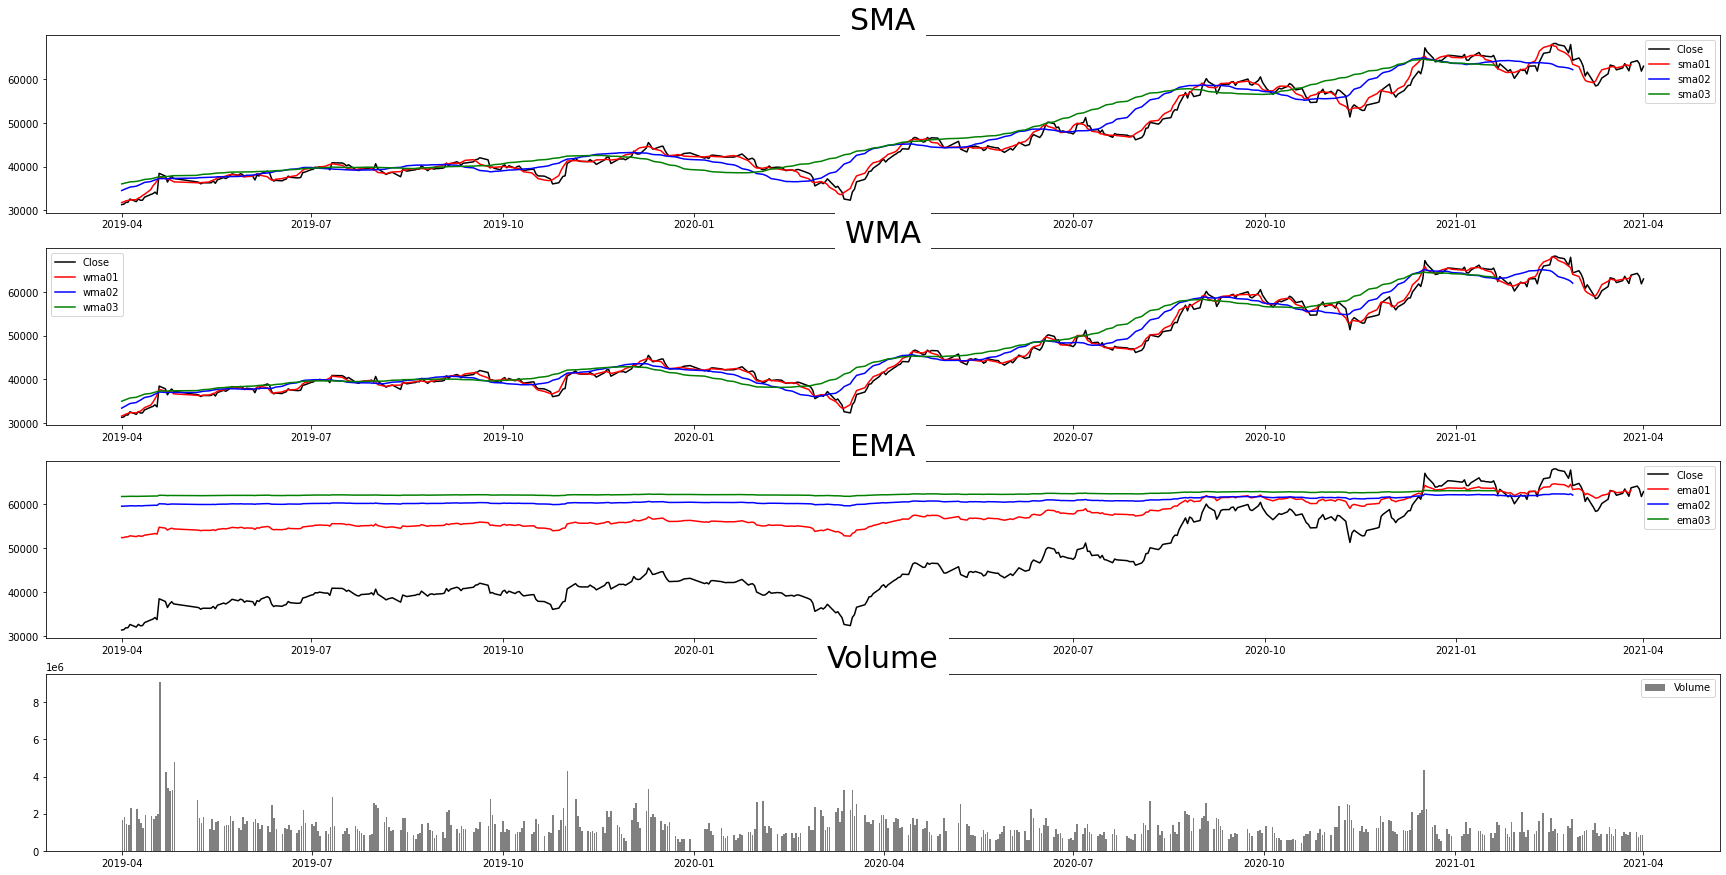

In [ ]:
SPG('2019-04-01','2021-04-01','7974.jp')

In [ ]:
#SharePricesPrediction = SPP
def SPP(start,end,company_code):
    #株価データをスクレイピングし、指定された範囲に前処理する。
    df = data.DataReader(company_code,"stooq")
    df = df[(df.index>=start) & (df.index<=end)]
    #print(df)
    date = df.index
    price = df["Close"].to_numpy()
    df = df.drop('Close',axis=1)
    #print(df)
    #print(price)
    
    #重回帰分析の人工知能（AI）モデルを作成し、学習させる。
    model = LinearRegression()
    model.fit(df,price)
    
    #学習させたAIモデルの訓練データに対する精度を評価する。
    #print(price)
    #print(model.predict(df))
    print('Train_score')
    print('MAE:',mean_absolute_error(price,model.predict(df)))
    print('MSE:',mean_squared_error(price,model.predict(df)))
    print('RMSE:',np.sqrt(mean_squared_error(price,model.predict(df))))
    print('R^2:',model.score(df,price))
    print(pd.DataFrame(model.coef_,columns=['回帰係数'],index=df.columns))
    
    #予測データをデータテーブルに変換する。
    df_p = model.predict(df).reshape((len(model.predict(df)),1))
    #print(df_p)
    df_p = pd.DataFrame(data=df_p,index=date,columns=['Close_p'])
    #print(df_p)
    
    #実データと予測データをグラフにプロットする。
    plt.figure(figsize=(30,15))
    plt.subplot(2,1,1)
    plt.title('Train',color='black',backgroundcolor='white',size=30,loc='center')
    plt.plot(date,price,label='Close',color='red')
    plt.plot(date,df_p['Close_p'],label='Close_p',color='blue')
    plt.legend()
    
    #株価データを再度スクレイピングし、一年後の範囲で前処理する。
    #time = datetime.datetime(1,0,0,0,0,0,0)
    start = datetime.datetime.strptime(start,'%Y-%m-%d')
    end = datetime.datetime.strptime(end,'%Y-%m-%d')
    df = data.DataReader(company_code,"stooq")
    df = df[(df.index>=start+datetime.timedelta(days=365)) & (df.index<=end+datetime.timedelta(days=365))]    
    date = df.index
    price = df['Close']
    df = df.drop('Close',axis=1)
    
    #テストデータに対する精度を評価する。
    print('Test_score')
    print('MAE:',mean_absolute_error(price,model.predict(df)))
    print('MSE:',mean_squared_error(price,model.predict(df)))
    print('RMSE:',np.sqrt(mean_squared_error(price,model.predict(df))))
    print('R^2',model.score(df,price))
    
    #予測データをデータテーブルに変換する。
    df_p = model.predict(df).reshape((len(model.predict(df)),1))
    df_p = pd.DataFrame(data=df_p,index=date,columns=['Close_p'])
    
    #実データと予測データをグラフにプロットする。
    plt.subplot(2,1,2)
    plt.title('Test',color='black',backgroundcolor='white',size=30,loc='center')
    plt.plot(date,price,label='Close',color='red')
    plt.plot(date,df_p['Close_p'],label='Close_p',color='blue')
    plt.legend()

Train_score
MAE: 170.16621380383262
MSE: 49760.58983764355
RMSE: 223.07081798756994
R^2: 0.9934782522872411
            回帰係数
Open   -0.544080
High    0.831340
Low     0.712041
Volume -0.000002
Test_score
MAE: 269.783896289404
MSE: 117204.31996355885
RMSE: 342.35116468848014
R^2 0.9979477977373024


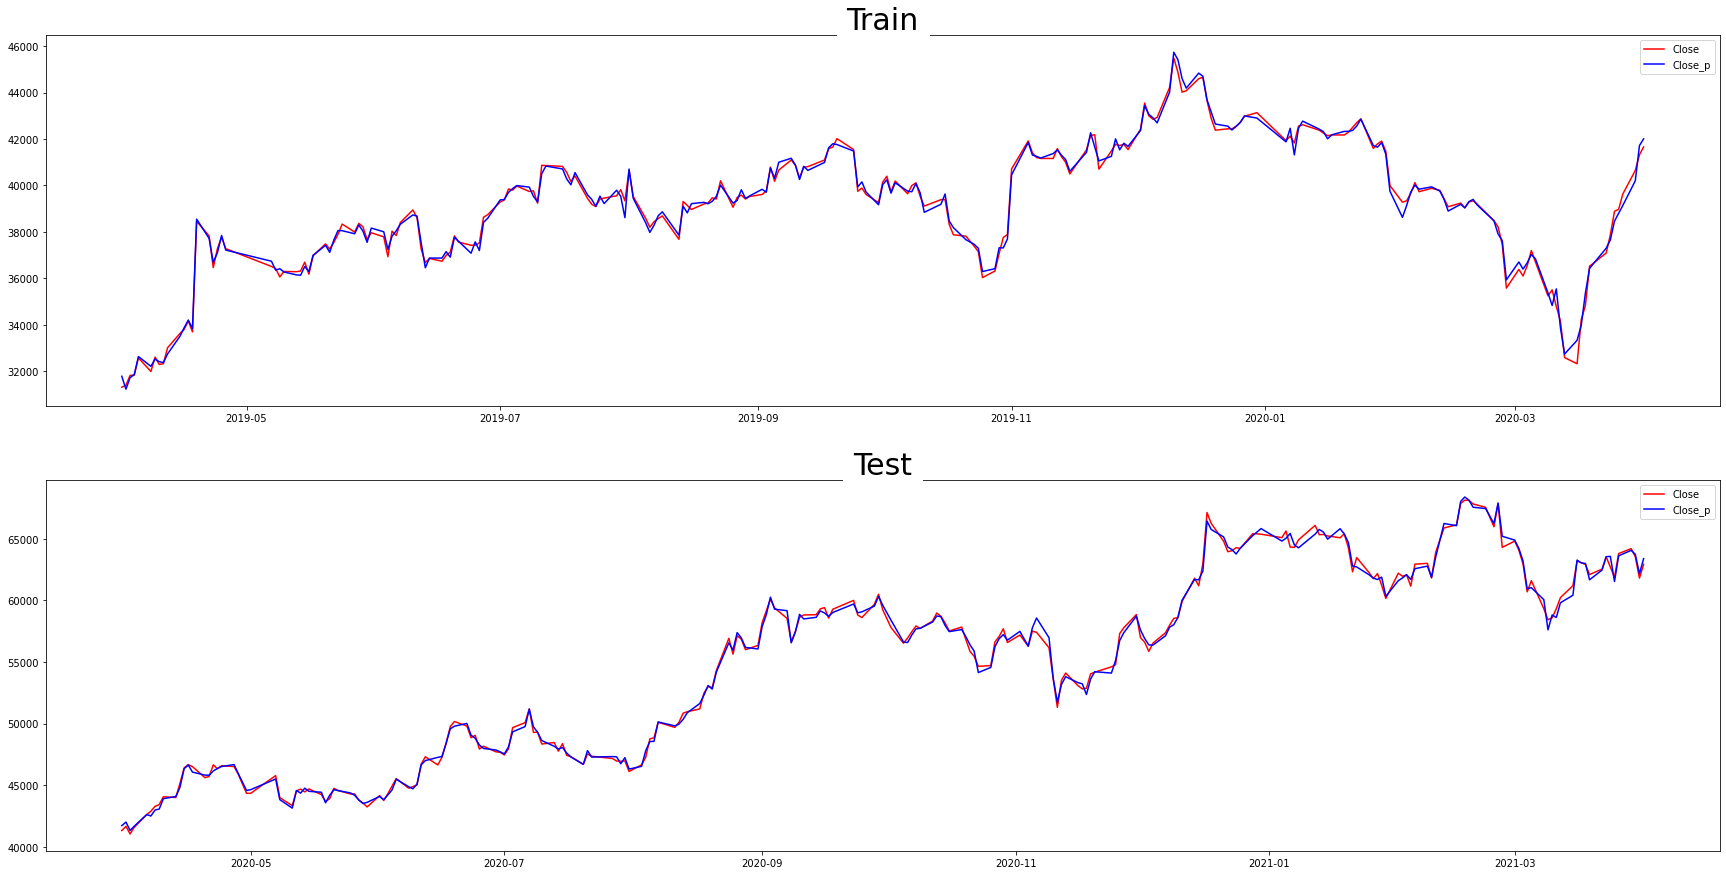

In [ ]:
SPP('2019-04-01','2020-04-01','7974.jp')